In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import seaborn as sns
from src.data import load_dataset

2025-01-21 16:06:01.473397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737475561.494524    1532 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737475561.500221    1532 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(train_ds, val_ds, test_ds), ds_info = load_dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

W0000 00:00:1737475775.474996    1532 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Shuffling /workspaces/cnn-cifar-100/data/raw/cifar100/incomplete.9F3Z14_3.0.2/cifar100-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /workspaces/cnn-cifar-100/data/raw/cifar100/incomplete.9F3Z14_3.0.2/cifar100-test.tfrecord*...:   0%…

Dataset cifar100 downloaded and prepared to /workspaces/cnn-cifar-100/data/raw/cifar100/3.0.2. Subsequent calls will reuse this data.


In [3]:
train_ds: tf.data.Dataset = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds: tf.data.Dataset = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds: tf.data.Dataset = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [4]:
print(f"Train: {len(train_ds)}")
print(f"Validation: {len(val_ds)}")
print(f"Test: {len(test_ds)}")
print(ds_info.features)

Train: 40000
Validation: 10000
Test: 10000
FeaturesDict({
    'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
})


## Распределение классов

In [5]:
train_df = tfds.as_dataframe(train_ds, ds_info)
val_df = tfds.as_dataframe(val_ds, ds_info)
test_df = tfds.as_dataframe(test_ds, ds_info)

In [6]:
def create_labels_count_df(col_name):
    combined_df = pd.concat(
        [
            train_df.assign(group="train"),
            val_df.assign(group="val"),
            test_df.assign(group="test"),
        ]
    )

    combined_df["label"] = combined_df[col_name].apply(
        ds_info.features[col_name].int2str
    )

    return combined_df.groupby(["group", "label"]).size().reset_index(name="count")


label_counts = create_labels_count_df("label")
coarse_label_counts = create_labels_count_df("coarse_label")

In [7]:
def plot_labels_distribution(label_counts):
    _, _ = plt.subplots(figsize=(10, 16))

    sns.set_color_codes("pastel")
    sns.barplot(
        label_counts[label_counts["group"] == "train"],
        y="label",
        x="count",
        orient="h",
        color="b",
        label="Train Data",
    )

    sns.set_color_codes("reset")
    sns.barplot(
        label_counts[label_counts["group"] == "val"],
        y="label",
        x="count",
        orient="h",
        color="r",
        label="Validation Data",
    )

    sns.set_color_codes("muted")
    sns.barplot(
        label_counts[label_counts["group"] == "test"],
        y="label",
        x="count",
        orient="h",
        color="g",
        alpha=0.5,
        label="Test Data",
    )
    plt.show()

In [8]:
plot_labels_distribution(label_counts)

In [9]:
plot_labels_distribution(coarse_label_counts)

Классы примерно одинаково распределены по датасетам после разбивки на train и validation

## Примеры изображений


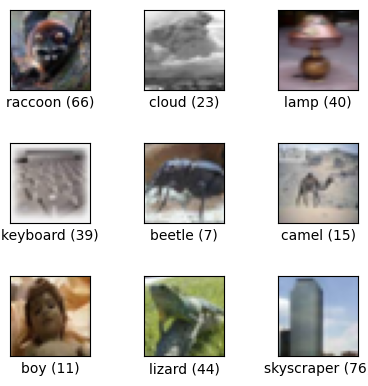

In [10]:
fig = tfds.show_examples(train_ds, ds_info, label_key="label", plot_scale=1.5)

## Итог:

Имеем датасет на 60000 изображений.
Разбили на 3 части:
- train - 40000
- validation - 10000
- test - 10000

Features:
- id - название/id картинки
- coarse_label - метка широкого класса
- label - метка узкого класса
- image - изображение 32x32 на 3 канала